## TASK-2 Stock Market Prediction And Forecasting Using Stacked LSTM

### Import the necessary libraries 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
url = 'https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv'
dataset_train = pd.read_csv(url)
training_set = dataset_train.iloc[:,1:2].values

In [3]:
dataset_train.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [4]:
data_close = dataset_train['Close']

In [5]:
data_close

0       233.75
1       233.25
2       234.25
3       236.10
4       233.30
         ...  
2030    118.65
2031    117.60
2032    120.65
2033    120.90
2034    121.55
Name: Close, Length: 2035, dtype: float64

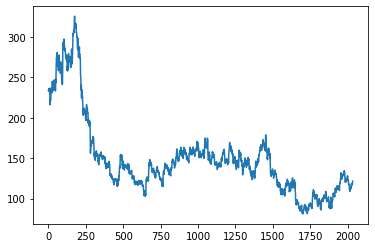

In [6]:
plt.plot(data_close)

###### Since LSTM are sensitive to the scale of the data, so we apply MinMax Scaler to transfer our values between 0 and 1

### Data Normalization

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
data_close = scaler.fit_transform(np.array(data_close).reshape(-1,1))

In [8]:
data_close.shape

(2035, 1)

In [9]:
print(data_close)

[[0.62418301]
 [0.62214052]
 [0.62622549]
 ...
 [0.1621732 ]
 [0.16319444]
 [0.16584967]]


### Train and Test Split 

In [10]:
training_size = int(len(data_close) * 0.75)
test_size = len(data_close) - training_size
train_data, test_data = data_close[0:training_size,:], data_close[training_size:len(data_close),:1]

In [11]:
def create_dataset(dataset, time_step = 1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return np.array(dataX), np.array(dataY)

In [12]:
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [13]:
#Reshape the input to be [samples, time steps, features] which is the requirement of LSTM
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)

In [14]:
#create the LSTM Model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (100, 1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
model.summary()

In [ ]:
model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=100, batch_size=64, verbose=1)

In [ ]:
#Lets predict and check performance metrics
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

In [ ]:
#Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [ ]:
#Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train, train_predict))

In [ ]:
#Test Data RMSE
math.sqrt(mean_squared_error(y_test, test_predict))

In [ ]:
# plotting 
#shift train prediction for plotting
look_back = 100
trainPredictionPlot = np.empty_like(data_close)
trainPredictionPlot[:,:] = np.nan
trainPredictionPlot[look_back:len(train_predict)+look_back, :] = train_predict

#shift test prediction for plotting
testPredictionPlot = np.empty_like(data_close)
testPredictionPlot[:,:] = np.nan
testPredictionPlot[len(train_predict) + (look_back * 2)+1:len(data_close)-1, :] = test_predict

#Plot baseline and predictions
plt.plot(scaler.inverse_transform(data_close))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


##### Predict the next 30 days Stock Price 

In [ ]:
len(test_data), x_test.shape

In [ ]:
x_input = test = test_data[409:].reshape(1,-1)
x_input.shape

In [ ]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [ ]:
lst_output=[]
n_steps=100
nextNumberOfDays = 30
i=0

while(i<nextNumberOfDays):
    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input= x_input.reshape((1,n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input= x_input.reshape((1,n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
print(lst_output)

In [ ]:
day_new = np.arange(1,101)
day_pred = np.arange(101,131)

In [ ]:
df3 = data_close.tolist()
df3.extend(lst_output)

In [ ]:
len(data_close)

In [ ]:
plt.plot(day_new, scaler.inverse_transform(data_close[1935:]))
plt.plot(day_pred, scaler.inverse_transform(lst_output))
